# Volatility and Business News

The goal of this notebook is to fit a Lasso model to news-based variables in order to explain/forecast changes in the VIX Index.

The news-based signals are taken from Business News and Business Cycles (2024, JF): Available here: https://onlinelibrary.wiley.com/doi/full/10.1111/jofi.13377

---

In [5]:
# Required packages
import pandas as pd
import numpy as np
import warnings

import matplotlib.pyplot as plt
import statsmodels.api as sm

from statsmodels.tsa.stattools import adfuller as adf
from statsmodels.graphics.gofplots import qqplot
from pandas.plotting import register_matplotlib_converters
from pandas.plotting import autocorrelation_plot

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error

import ssl
ssl._create_default_https_context = ssl._create_stdlib_context


In [2]:
%matplotlib inline
register_matplotlib_converters()
warnings.filterwarnings('ignore')

### 1. $\quad$ Data

We'll use a function to download the FRED-MD dataset directly from the FRED website.

Alternatively, the data can be manually downloaded here:

https://www.stlouisfed.org/research/economists/mccracken/fred-databases

#### 1.1. $\quad$ Data download

In [16]:
# Retrieve the data
def load_data(fred_path: str):
    """
    Function to load data from FRED.

    Args:
    fred_path (str): URL to fetch the dataset from FRED.

    Returns:
    df: Loaded dataset
    tcodes: Transformation codes
    """

    print("Be patient: loading from FRED (2 minutes)")
    df = pd.read_csv(fred_path)[:-3]
    print("Done")

    tcodes = df.iloc[0, 1:]  # data tickers
    df.drop(0, inplace=True) # Drop unnecessary row

    # Set index to date and format it as datetime
    df = df.set_index("sasdate", drop=True)
    df.index = pd.to_datetime(df.index, format='%m/%d/%Y')
    df.index.name = "date"

    return df, tcodes

In [17]:
fred_path = 'https://www.stlouisfed.org/-/media/project/frbstl/stlouisfed/research/fred-md/monthly/2025-07-md.csv?sc_lang=en&hash=A1E7A098FEFE58C453870371DB34E6AF'

# Load the data
df, tcodes = load_data(fred_path)

df

Be patient: loading from FRED (2 minutes)
Done


,RPI,W875RX1,DPCERA3M086SBEA,CMRMTSPLx,RETAILx,INDPRO,IPFPNSS,IPFINAL,IPCONGD,IPDCONGD,...,DNDGRG3M086SBEA,DSERRG3M086SBEA,CES0600000008,CES2000000008,CES3000000008,UMCSENTx,DTCOLNVHFNM,DTCTHFNM,INVEST,VIXCLSx
date,,,,,,,,,,,,,,,,,,,,,
1959-01-01,2583.560,2426.0,15.188,2.766768e+05,17689.23968,21.9616,23.3868,22.2620,31.6664,18.9498,...,18.294,10.152,2.13,2.45,2.04,NaN,6476.00,12298.00,84.2043,NaN
1959-02-01,2593.596,2434.8,15.346,2.787140e+05,17819.01912,22.3917,23.7024,22.4549,31.8987,19.0492,...,18.302,10.167,2.14,2.46,2.05,NaN,6476.00,12298.00,83.5280,NaN
1959-03-01,2610.396,2452.7,15.491,2.777753e+05,17967.91336,22.7142,23.8459,22.5651,31.8987,19.4223,...,18.289,10.185,2.15,2.45,2.07,NaN,6508.00,12349.00,81.6405,NaN
1959-04-01,2627.446,2470.0,15.435,2.833627e+05,17978.97983,23.1981,24.1903,22.8957,32.4019,19.5466,...,18.300,10.221,2.16,2.47,2.08,NaN,6620.00,12484.00,81.8099,NaN
1959-05-01,2642.720,2486.4,15.622,2.853072e+05,18119.82573,23.5476,24.3911,23.1161,32.5567,19.9445,...,18.280,10.238,2.17,2.48,2.08,95.3,6753.00,12646.00,80.7315,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-11-01,20126.456,16412.1,122.396,1.545040e+06,712145.00000,101.9503,99.3545,98.8365,100.8370,102.2327,...,119.230,129.380,31.59,36.26,28.22,71.8,556011.41,938335.20,5381.7462,15.9822
2024-12-01,20148.534,16434.6,123.077,1.558008e+06,717662.00000,103.0447,100.4234,99.9346,101.6683,100.6563,...,119.746,129.875,31.72,36.43,28.33,74.0,559364.75,943484.76,5366.3388,15.6997
2025-01-01,20181.340,16430.3,122.386,1.542895e+06,711461.00000,102.8805,100.6125,100.1338,101.5923,98.5588,...,120.458,130.293,31.91,36.56,28.58,71.7,559708.93,944674.17,5351.9157,16.8122


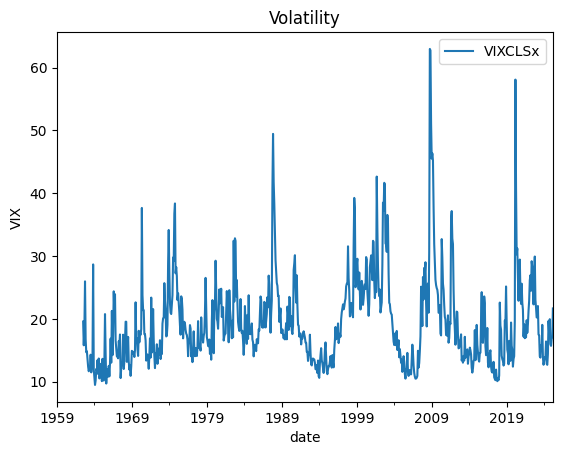

In [32]:
df[["VIXCLSx"]].plot(title = f"Volatility")
plt.ylabel("VIX")
plt.show()

Similarly, we import the news-based variables.

In [34]:
topics = pd.read_csv("Monthly_Topic_Attention_Theta.csv")
topics = topics.set_index("date")
topics.index = pd.to_datetime(topics.index)

topics.head()

,Natural disasters,Internet,Soft drinks,Mobile devices,Profits,M&A,Changes,Police/crime,Research,Executive pay,...,European politics,Size,NASD,Mexico,Retail,Long/short term,Wide range,Lawsuits,UK,Revenue growth
date,,,,,,,,,,,,,,,,,,,,,
1984-01-01,0.003393,0.001054,0.003522,0.001552,0.009622,0.004586,0.003639,0.004703,0.004628,0.003310,...,0.009105,0.003894,0.003490,0.004669,0.005357,0.004293,0.004955,0.008534,0.004675,0.002961
1984-02-01,0.004640,0.000975,0.004115,0.001611,0.008956,0.005205,0.003648,0.004393,0.004115,0.003534,...,0.007414,0.004008,0.004439,0.003033,0.004055,0.004467,0.004519,0.008337,0.004582,0.003218
1984-03-01,0.005294,0.001018,0.003355,0.001546,0.005529,0.006112,0.003461,0.004456,0.004211,0.003181,...,0.008363,0.003832,0.004134,0.003516,0.004393,0.003914,0.004839,0.009045,0.004731,0.003135
1984-04-01,0.004181,0.000927,0.003663,0.001612,0.010934,0.004572,0.003014,0.005091,0.003741,0.004565,...,0.006124,0.003205,0.003686,0.003467,0.005167,0.004159,0.004557,0.008473,0.003942,0.003276
1984-05-01,0.004179,0.001012,0.003105,0.001612,0.005622,0.004704,0.002953,0.005669,0.003715,0.004073,...,0.007005,0.003816,0.005254,0.003947,0.005518,0.004400,0.005332,0.010317,0.004083,0.003211


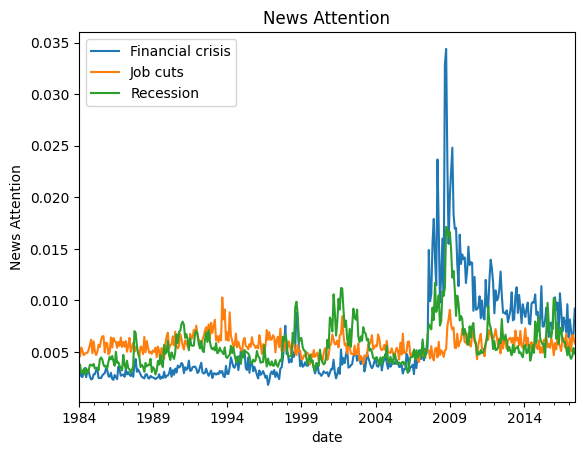

In [35]:
topics[["Financial crisis","Job cuts","Recession"]].plot(title = f"News Attention")
plt.ylabel("News Attention")
plt.show()

#### 1.2. $\quad$ Data pre-processing

##### Transform the Data

In [36]:
def transxf(x, tcode):
    """
    DESCRIPTION:
    This function transforms a single series (in a column vector)
    as specified by a given transformation code.

    INPUT:
        x      : Series (in a column vector) to be transformed
        tcode  : Transformation code (1-7)

    OUTPUT:
        result : Transformed series (as a column vector)

    """
    # Number of observations (including missing values)
    n = x.size

    # Value close to zero
    small = 1e-6

    # Allocate output variables
    y = np.nan * np.ones(n)
    y1 = np.nan * np.ones(n)

    # Initialize result to ensure it's always defined
    result = np.nan * np.ones(n)

    # Transformation logic
    if tcode == 1:  # No transformation: x(t)
        result = x

    elif tcode == 2:  # First difference: x(t) - x(t-1)
        y[1:] = x[1:] - x[:-1]
        result = y

    elif tcode == 3:  # Second difference: (x(t) - x(t-1)) - (x(t-1) - x(t-2))
        y[2:] = x[2:] - 2 * x[1:-1] + x[:-2]
        result = y

    elif tcode == 4:  # Natural log: ln(x)
        if np.min(x) < small:
            result = np.nan
        else:
            result = np.log(x)

    elif tcode == 5:  # First difference of natural log: ln(x) - ln(x-1)
        if np.min(x[pd.notnull(x)]) > small:
            log_x = np.log(x)
            y[1:] = log_x[1:] - log_x[:-1]
            result = y

    elif tcode == 6:  # Second difference of natural log
        if np.min(x[pd.notnull(x)]) > small:
            log_x = np.log(x)
            y[2:] = log_x[2:] - 2 * log_x[1:-1] + log_x[:-2]
            result = y

    elif tcode == 7:  # First difference of percent change
        y1[1:] = (x[1:] - x[:-1]) / x[:-1]
        y[2:] = y1[2:] - y1[1:-1]
        result = y

    return result

In [38]:
yt = []             # Initialize output variable
N = df.shape[1]     # Number of series kept

for i in range(N):
    dum = transxf(df.iloc[:, i].values, tcodes[i])
    yt.append(dum)

transformed_data = pd.DataFrame(yt).T
transformed_data.columns = df.columns
transformed_data.index = df.index

transformed_data.head()

,RPI,W875RX1,DPCERA3M086SBEA,CMRMTSPLx,RETAILx,INDPRO,IPFPNSS,IPFINAL,IPCONGD,IPDCONGD,...,DNDGRG3M086SBEA,DSERRG3M086SBEA,CES0600000008,CES2000000008,CES3000000008,UMCSENTx,DTCOLNVHFNM,DTCTHFNM,INVEST,VIXCLSx
date,,,,,,,,,,,,,,,,,,,,,
1959-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1959-02-01,0.003877,0.003621,0.010349,0.007336,0.007310,0.019395,0.013405,0.008628,0.007309,0.005232,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1959-03-01,0.006457,0.007325,0.009404,-0.003374,0.008321,0.014300,0.006036,0.004896,0.000000,0.019397,...,-0.001148,0.000292,-0.000022,-0.008147,0.004819,NaN,0.004929,0.004138,-0.014792,NaN
1959-04-01,0.006510,0.007029,-0.003622,0.019915,0.000616,0.021080,0.014339,0.014545,0.015652,0.006379,...,0.001312,0.001760,-0.000022,0.012203,-0.004890,NaN,0.012134,0.006734,0.024929,NaN
1959-05-01,0.005796,0.006618,0.012043,0.006839,0.007803,0.014954,0.008267,0.009580,0.004766,0.020152,...,-0.001695,-0.001867,-0.000021,-0.004090,-0.004819,NaN,0.002828,0.002020,-0.015342,NaN


Now, we need to merge the two dataframes into a single one.

We do this by merging of the datetime index.

In [66]:
# Merge RV and topics data
data = transformed_data.merge(topics, left_index=True, right_index=True, how='inner')
data.dropna(inplace = True)

data

,RPI,W875RX1,DPCERA3M086SBEA,CMRMTSPLx,RETAILx,INDPRO,IPFPNSS,IPFINAL,IPCONGD,IPDCONGD,...,European politics,Size,NASD,Mexico,Retail,Long/short term,Wide range,Lawsuits,UK,Revenue growth
date,,,,,,,,,,,,,,,,,,,,,
1992-03-01,0.001467,0.000590,0.001830,0.004017,-0.003411,0.008381,0.008338,0.008783,0.008871,0.020222,...,0.007559,0.004602,0.005096,0.003463,0.005470,0.004900,0.004505,0.011003,0.004700,0.003811
1992-04-01,0.003587,0.002574,0.000833,0.006642,0.007998,0.007652,0.007433,0.007499,0.009322,0.018415,...,0.007720,0.004291,0.004292,0.003226,0.004826,0.004873,0.004242,0.010177,0.004758,0.004157
1992-05-01,0.005188,0.005346,0.005164,-0.008738,0.003433,0.003283,0.005520,0.005877,0.006537,0.030857,...,0.006226,0.004483,0.005410,0.003814,0.006963,0.004490,0.004436,0.009150,0.005569,0.004542
1992-06-01,0.004069,0.004316,0.002703,0.010487,0.004564,0.000564,-0.002470,-0.003155,-0.004910,-0.013889,...,0.007676,0.004514,0.005469,0.004664,0.005662,0.004452,0.004766,0.010712,0.003952,0.003928
1992-07-01,-0.000888,-0.001450,0.003318,0.013303,0.010183,0.009022,0.010146,0.011477,0.013214,0.026242,...,0.006508,0.004303,0.004326,0.005853,0.005236,0.004183,0.004361,0.009751,0.003646,0.004260
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-02-01,0.002944,0.003531,0.000536,-0.001596,-0.000276,-0.003855,-0.007422,-0.010006,-0.014672,-0.004445,...,0.011896,0.005128,0.003284,0.007718,0.004835,0.005311,0.004215,0.005482,0.003075,0.006990
2017-03-01,0.003659,0.003937,0.004429,-0.002098,-0.001315,0.006214,0.004644,0.006226,0.005517,-0.014305,...,0.014791,0.005581,0.002946,0.004698,0.005293,0.005542,0.004170,0.004596,0.004484,0.005598
2017-04-01,0.001797,0.002913,0.000332,-0.003526,0.003449,0.009969,0.012176,0.015066,0.009124,0.024890,...,0.020162,0.006293,0.003023,0.004557,0.005231,0.004725,0.004145,0.005918,0.002775,0.005881


Define the target, as well as the in-sample and out-of-sample periods.

In [67]:
# Prepare data
data["Target"] = data["VIXCLSx"]

X = data[topics.columns]
y = data[["Target"]]

#Split train and test sets (for forecasting)
split = int(0.60 * data.shape[0])
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]


### 2. $\quad$ Fitting and evaluating and the model

In [68]:
# Find optimal alpha using validation set
alpha_values = np.logspace(-4, 2, 50)  # Penalty parameters to test

best_alpha = None
best_lasso = None

desired_nonzero = 5

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

for alpha in alpha_values:
    lasso = Lasso(alpha=alpha, max_iter=2000, random_state=42, positive=True)
    lasso.fit(X_scaled, y)
    nonzero_count = np.sum(lasso.coef_ != 0)

    if nonzero_count == desired_nonzero:
        best_alpha = alpha
        best_lasso = lasso
        break

y_hat = best_lasso.predict(X_scaled)


In [71]:
df_coefficients = pd.DataFrame(lasso.coef_.reshape(1,-1), columns=X.columns)
# Create a boolean mask for columns with at least one non-zero value
non_zero_columns_mask = (df_coefficients != 0).any(axis=0)

# Filter the DataFrame to show only non-zero columns
df_non_zero_cols = df_coefficients.loc[:, non_zero_columns_mask]
df_non_zero_cols


,Problems,Small caps,Recession,Investment banking,Bear/bull market
0,1.819311,1.1314,3.54961,0.058779,0.453183


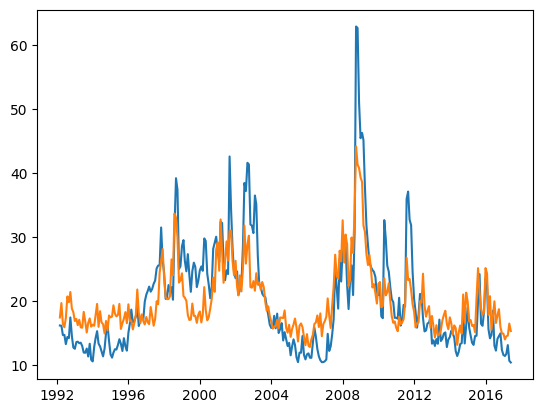

In [72]:
plt.plot(data.index, y)
plt.plot(data.index, y_hat)
plt.show()

### 3. $\quad$ Forecasting Example

We'll first do this with OLS:

$\hat{\beta} = (X'X)^{-1}X'Y$

In [25]:
results = sm.OLS(y_train, X_train).fit()
y_hat = results.predict(X_test)
y_hat_is = results.predict(X_train)

results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 Target   R-squared:                       0.997
Model:                            OLS   Adj. R-squared:                  0.728
Method:                 Least Squares   F-statistic:                     3.700
Date:                Thu, 14 Aug 2025   Prob (F-statistic):              0.237
Time:                        12:59:44   Log-Likelihood:                -97.673
No. Observations:                 182   AIC:                             555.3
Df Residuals:                       2   BIC:                             1132.
Df Model:                         179                                         
Covariance Type:            nonrobust                                         
==============================================================================================
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Natural disasters            337.3252    891.415      0.378      0.742   -3498.122    4172.773
Internet                    -847.0487   2201.029     -0.385      0.737   -1.03e+04    8623.215
Soft drinks                 2572.4214   5929.833      0.434      0.707   -2.29e+04    2.81e+04
Mobile devices              1480.8681   6123.271      0.242      0.831   -2.49e+04    2.78e+04
Profits                       67.6783   3050.818      0.022      0.984   -1.31e+04    1.32e+04
M&A                         -278.3792   4100.470     -0.068      0.952   -1.79e+04    1.74e+04
Changes                    -3258.3820   1.53e+04     -0.212      0.852   -6.93e+04    6.28e+04
Police/crime                -614.9282   1987.413     -0.309      0.786   -9166.077    7936.220
Research                   -1459.2695   3756.536     -0.388      0.735   -1.76e+04    1.47e+04
Executive pay                419.4312   4696.775      0.089      0.937   -1.98e+04    2.06e+04
Mid-size cities              469.4997   6480.503      0.072      0.949   -2.74e+04    2.84e+04
Scenario analysis            622.7090   8399.459      0.074      0.948   -3.55e+04    3.68e+04
Economic ideology           1085.3712   3053.558      0.355      0.756   -1.21e+04    1.42e+04
Middle east                  -38.7842    871.077     -0.045      0.969   -3786.725    3709.156
Savings & loans             -494.6830   6469.302     -0.076      0.946   -2.83e+04    2.73e+04
IPOs                        2642.4724   2601.522      1.016      0.417   -8550.973    1.38e+04
Restraint                   1498.4160   1.12e+04      0.134      0.906   -4.65e+04    4.95e+04
Electronics                  962.9523   5346.421      0.180      0.874    -2.2e+04     2.4e+04
Record high                 1542.0841   4604.593      0.335      0.770   -1.83e+04    2.14e+04
Connecticut                 1048.3499   7879.376      0.133      0.906   -3.29e+04     3.5e+04
Steel                       1256.9968   2504.887      0.502      0.666   -9520.662     1.2e+04
Bond yields                 1296.6663   3771.448      0.344      0.764   -1.49e+04    1.75e+04
Small business              1320.6075   9766.277      0.135      0.905   -4.07e+04    4.33e+04
Cable                       2156.9439   2309.235      0.934      0.449   -7778.894    1.21e+04
Fast food                    -85.6065   4769.781     -0.018      0.987   -2.06e+04    2.04e+04
Disease                     -458.8103   1217.971     -0.377      0.743   -5699.316    4781.696
Activists                  -3929.4376   1.81e+04     -0.217      0.848   -8.17e+04    7.39e+04
Competition                 2291.3910   8821.628      0.260      0.819   -3.57e+04    4.02e+04
Music industry               641.2476   2172.719      0.295      0.796   -8707.206    9989.701
Short sales                 1875.6386   1.1

In [41]:
# ============================================================================
# OPTION 2: Run the Lasso penalized regression
# ============================================================================

# Find optimal alpha using validation set
alpha_values = np.logspace(-4, 2, 50)  # Penalty parameters to test
validation_size = 72

best_alpha = None
best_lasso = None
best_mse_penalized = float('inf')


scaler = StandardScaler()
X_train, X_test = scaler.fit_transform(X_train), scaler.transform(X_test)

for alpha in alpha_values:
    lasso = Lasso(alpha=alpha, max_iter=2000, random_state=42)
    lasso.fit(X_train[:-validation_size], y_train[:-validation_size])
    prediction = lasso.predict(X_train[len(X_train)-validation_size:])
    mse = mean_squared_error(y_train[len(X_train)-validation_size:], prediction)

    if mse < best_mse_penalized:
        best_mse_penalized = mse
        best_alpha = alpha
        best_lasso = lasso

y_hat = best_lasso.predict(X_test)
y_hat_is = best_lasso.predict(X_train)

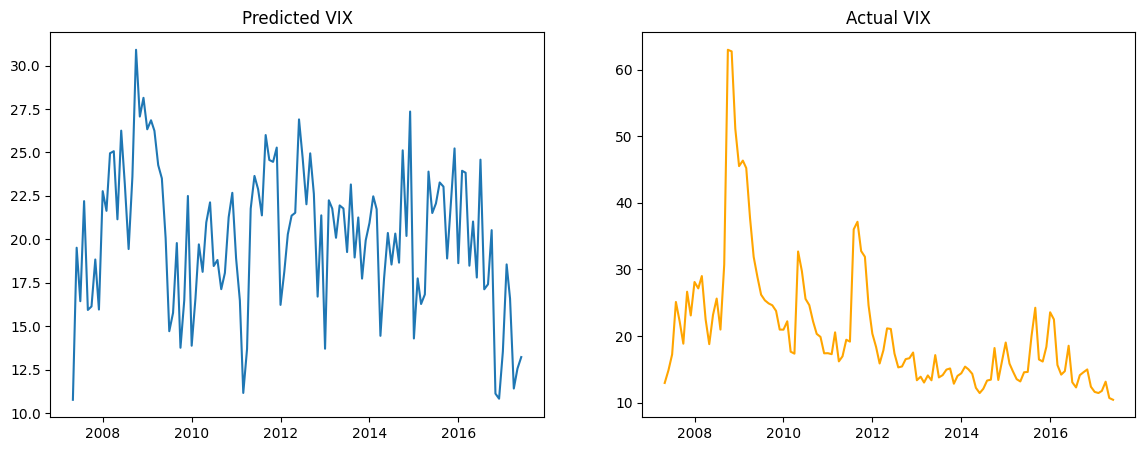

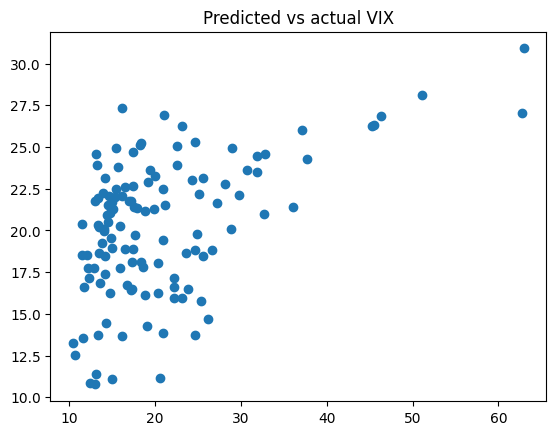

In [42]:
# Perform out of sample prediction
plt.figure(figsize = (14,5))

#Predicted RV
plt.subplot(1,2,1)
plt.plot(y_test.index, y_hat)
plt.title("Predicted VIX")

#Actual RV
plt.subplot(1,2,2)
plt.plot(y_test.index, y_test, color = "orange")
plt.title("Actual VIX")
plt.show()

plt.scatter(y_test, y_hat)
plt.title("Predicted vs actual VIX")
plt.show()

In [43]:
# Metrics
def score(y_hat, y, metric):
    """Return metrics of y_hat vs. y

    Args:
        y_hat (np.array): Predicted values
        y (np.array): Actual values
        metric (str): Metric to use

    Returns:
        float: The metric
    """
    if metric == "MSE":
        return np.mean( (y_hat-y)**2)
    elif metric == "R_squared":
        ss_res = np.sum( (y - y_hat)**2 )
        ss_tot = np.sum( (y - np.average(y)) **2)
        return 1 - ss_res/ss_tot
    elif metric == "MAE":
        return np.mean( np.abs(y-y_hat))

In [44]:
#In-sample scores
print("In-sample scores")


mse_is = score(y_hat_is, y_train.values.ravel(), "MSE")
r_sq_is = score(y_hat_is, y_train.values.ravel(), "R_squared")
mae_is = score(y_hat_is, y_train.values.ravel(), "MAE")

print(f"MSE:{mse_is}, R^2:{r_sq_is}, MAE:{mae_is}")

print("----------------")

#Out-of-sample scores
print("Out-of-sample scores")

mse_oos = score(y_hat, y_test.values.ravel(), "MSE")
r_sq_oos = score(y_hat, y_test.values.ravel(), "R_squared")
mae_oos = score(y_hat, y_test.values.ravel(), "MAE")

print(f"MSE:{mse_oos}, R^2:{r_sq_oos}, MAE:{mae_oos}")

In-sample scores
MSE:16.759840441372635, R^2:0.7053466502649325, MAE:2.178458336582791
----------------
Out-of-sample scores
MSE:68.08379400922077, R^2:0.24717661151792203, MAE:6.228194343036255
